In [3]:
# Load the uploaded CA MSA LOS exposure and HPI quarterly data, inspect structure

import pandas as pd

ca_los = pd.read_csv('ca_msa_los_exposure.csv')
ca_hpi = pd.read_csv('hpi_california_quarterly.csv')

print(ca_los.head())
print(ca_hpi.head())

   place_id              place_name los_exposure
0     12540  Bakersfield-Delano, CA          low
1     17020               Chico, CA          low
2     20940           El Centro, CA          low
3     23420              Fresno, CA          low
4     25260    Hanford-Corcoran, CA          low
      hpi_type        hpi_flavor  frequency level              place_name  \
0  traditional  all-transactions  quarterly   MSA  Bakersfield-Delano, CA   
1  traditional  all-transactions  quarterly   MSA  Bakersfield-Delano, CA   
2  traditional  all-transactions  quarterly   MSA  Bakersfield-Delano, CA   
3  traditional  all-transactions  quarterly   MSA  Bakersfield-Delano, CA   
4  traditional  all-transactions  quarterly   MSA  Bakersfield-Delano, CA   

  place_id    yr  period  index_nsa  index_sa  
0    12540  1977       3      50.59       NaN  
1    12540  1977       4      53.61       NaN  
2    12540  1978       1      50.32       NaN  
3    12540  1978       2      57.61       NaN  
4  

In [9]:
import pandas as pd

# ca_los and ca_hpi already loaded
print("Year coverage:", ca_hpi['yr'].min(), ca_hpi['yr'].max())

print("Dtypes before:")
print("  ca_hpi place_id:", ca_hpi['place_id'].dtype)
print("  ca_los place_id:", ca_los['place_id'].dtype)

# Harmonize join key types (recommended: string IDs)
ca_hpi = ca_hpi.copy()
ca_los = ca_los.copy()

ca_hpi['place_id'] = ca_hpi['place_id'].astype('string').str.strip()
ca_los['place_id'] = ca_los['place_id'].astype('string').str.strip()

print("Dtypes after:")
print("  ca_hpi place_id:", ca_hpi['place_id'].dtype)
print("  ca_los place_id:", ca_los['place_id'].dtype)

# Merge LOS exposure info
merged = ca_hpi.merge(
    ca_los[['place_id', 'los_exposure']],
    on='place_id',
    how='left',
    validate='m:1'   # catches duplicate place_id in ca_los (common merge bug)
)

print(merged['los_exposure'].value_counts(dropna=False))
print(merged[['place_name', 'place_id', 'los_exposure']].drop_duplicates().head())

# Quick diagnostic: which HPI place_ids didn't find a match in ca_los?
unmatched = merged.loc[merged['los_exposure'].isna(), 'place_id'].dropna().unique()
print("Unmatched place_id count:", len(unmatched))
print("Example unmatched place_ids:", unmatched[:10])


Year coverage: 1975 2025
Dtypes before:
  ca_hpi place_id: object
  ca_los place_id: int64
Dtypes after:
  ca_hpi place_id: string
  ca_los place_id: string
los_exposure
low     2969
high    2680
NaN     1219
Name: count, dtype: int64
                 place_name place_id los_exposure
0    Bakersfield-Delano, CA    12540          low
193               Chico, CA    17020          low
379           El Centro, CA    20940          low
524              Fresno, CA    23420          low
720    Hanford-Corcoran, CA    25260          low
Unmatched place_id count: 2
Example unmatched place_ids: <StringArray>
['40140', 'CA']
Length: 2, dtype: string


In [10]:
# Clean and merge CA HPI quarterly data with LOS exposure; construct panel vars

import pandas as pd
import numpy as np

# Ensure place_id types are compatible for merge
ca_hpi['place_id'] = pd.to_numeric(ca_hpi['place_id'], errors='coerce').astype('Int64')
ca_los['place_id'] = pd.to_numeric(ca_los['place_id'], errors='coerce').astype('Int64')

# Merge LOS exposure info
merged = ca_hpi.merge(ca_los[['place_id', 'los_exposure']], on='place_id', how='left')

# Keep only high/low exposure MSAs
merged = merged[merged['los_exposure'].isin(['high', 'low'])].copy()

# Choose an index: use seasonally adjusted if available, else NSA
merged['index'] = merged['index_sa']
na_mask = merged['index'].isna()
merged.loc[na_mask, 'index'] = merged.loc[na_mask, 'index_nsa']
merged['index'] = pd.to_numeric(merged['index'], errors='coerce')
merged = merged.dropna(subset=['index'])

# Construct time variables
merged['year'] = merged['yr'].astype(int)
merged['quarter'] = merged['period'].astype(int)
merged['time_id'] = merged['year'].astype(str) + 'Q' + merged['quarter'].astype(str)

# Log price index
merged['ln_index'] = np.log(merged['index'])

# Treatment indicator: 1 if high LOS exposure
merged['treat_high'] = (merged['los_exposure'] == 'high').astype(int)

# Policy change at beginning of 2020 Q3
merged['post'] = ((merged['year'] > 2020) | ((merged['year'] == 2020) & (merged['quarter'] >= 3))).astype(int)

# COVID shock period: 2020Q2 through 2021Q4
merged['covid_period'] = (((merged['year'] == 2020) & (merged['quarter'] >= 2)) | (merged['year'] == 2021)).astype(int)

# For faster convergence, restrict sample to recent years
merged_sub = merged[merged['year'] >= 2015].copy()

print(merged_sub.head())
print(merged_sub[['year', 'quarter', 'time_id', 'treat_high', 'post', 'covid_period']].drop_duplicates().head())

        hpi_type        hpi_flavor  frequency level              place_name  \
150  traditional  all-transactions  quarterly   MSA  Bakersfield-Delano, CA   
151  traditional  all-transactions  quarterly   MSA  Bakersfield-Delano, CA   
152  traditional  all-transactions  quarterly   MSA  Bakersfield-Delano, CA   
153  traditional  all-transactions  quarterly   MSA  Bakersfield-Delano, CA   
154  traditional  all-transactions  quarterly   MSA  Bakersfield-Delano, CA   

     place_id    yr  period  index_nsa  index_sa los_exposure   index  year  \
150     12540  2015       1     188.16       NaN          low  188.16  2015   
151     12540  2015       2     189.48       NaN          low  189.48  2015   
152     12540  2015       3     191.71       NaN          low  191.71  2015   
153     12540  2015       4     192.27       NaN          low  192.27  2015   
154     12540  2016       1     193.03       NaN          low  193.03  2016   

     quarter time_id  ln_index  treat_high  post  

In [13]:
import numpy as np
import statsmodels.formula.api as smf

panel = merged_sub.copy()

# Fixed effects as categories (statsmodels-friendly)
panel['place_id_fe'] = panel['place_id'].astype(str).astype('category')
panel['time_fe']     = panel['time_id'].astype(str).astype('category')

# Cluster groups: plain object array (NOT pandas "string")
clusters = panel['place_id'].astype(str).to_numpy(dtype=object)

formula = 'ln_index ~ treat_high*post + treat_high*covid_period + C(place_id_fe) + C(time_fe)'

results = smf.ols(formula=formula, data=panel).fit(
    cov_type='cluster',
    cov_kwds={'groups': clusters}
)

print("\n".join(results.summary().as_text().split("\n")[0:25]))
print('DiD coefficient (treat_high:post):', results.params.get('treat_high:post'))
print('Cluster-robust SE:', results.bse.get('treat_high:post'))


                            OLS Regression Results                            
Dep. Variable:               ln_index   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 3.810e+13
Date:                Sun, 21 Dec 2025   Prob (F-statistic):          4.53e-138
Time:                        18:43:36   Log-Likelihood:                 2436.6
No. Observations:                1419   AIC:                            -4741.
Df Residuals:                    1353   BIC:                            -4394.
Df Model:                          65                                         
Covariance Type:              cluster                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/home/idies/mambaforge/envs/econark/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 68, but rank is 21
  warnings.warn('covariance of constraints does not have full '


In [18]:
# Fix Int64Dtype issues and rerun DiD regression with FE and clustered SE

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# merged_sub already exists from previous cell
panel = merged_sub.copy()

# Convert pandas nullable Int64 columns to standard int64 where possible
for col in panel.columns:
    if str(panel[col].dtype) == 'Int64':
        if panel[col].isna().any():
            panel[col] = panel[col].astype('float64')
        else:
            panel[col] = panel[col].astype('int64')

# Ensure FE identifiers are strings (safe for patsy C())
panel['place_id_fe'] = panel['place_id'].astype(str)
panel['time_fe'] = panel['time_id'].astype(str)

# Run OLS with MSA and time fixed effects
formula = 'ln_index ~ treat_high*post + treat_high*covid_period + C(place_id_fe) + C(time_fe)'

model = smf.ols(formula=formula, data=panel)
results = model.fit(cov_type='cluster', cov_kwds={'groups': panel['place_id']})

print("\n".join(results.summary().as_text().split("\n")[0:25]))
print('DiD coefficient (treat_high:post):')
print(results.params.get('treat_high:post', None))
print('Cluster-robust SE:')
print(results.bse.get('treat_high:post', None))

                            OLS Regression Results                            
Dep. Variable:               ln_index   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 3.810e+13
Date:                Sun, 21 Dec 2025   Prob (F-statistic):          4.53e-138
Time:                        18:56:17   Log-Likelihood:                 2436.6
No. Observations:                1419   AIC:                            -4741.
Df Residuals:                    1353   BIC:                            -4394.
Df Model:                          65                                         
Covariance Type:              cluster                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/home/idies/mambaforge/envs/econark/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 68, but rank is 21
  warnings.warn('covariance of constraints does not have full '


In [19]:
# Compute implied percent effect and 95% CI for DiD coefficient
import numpy as np

coef = -0.039752546202912006
se = 0.03016786830992958

# Approximate 95 percent CI on log scale
lower = coef - 1.96 * se
upper = coef + 1.96 * se

# Convert to percent effects
effect_pct = (np.exp(coef) - 1) * 100
lower_pct = (np.exp(lower) - 1) * 100
upper_pct = (np.exp(upper) - 1) * 100

t_val = coef / se

print(effect_pct)
print(lower_pct)
print(upper_pct)
print(t_val)

-3.8972780434136767
-9.415001678563295
1.956541796163247
-1.317711473496047


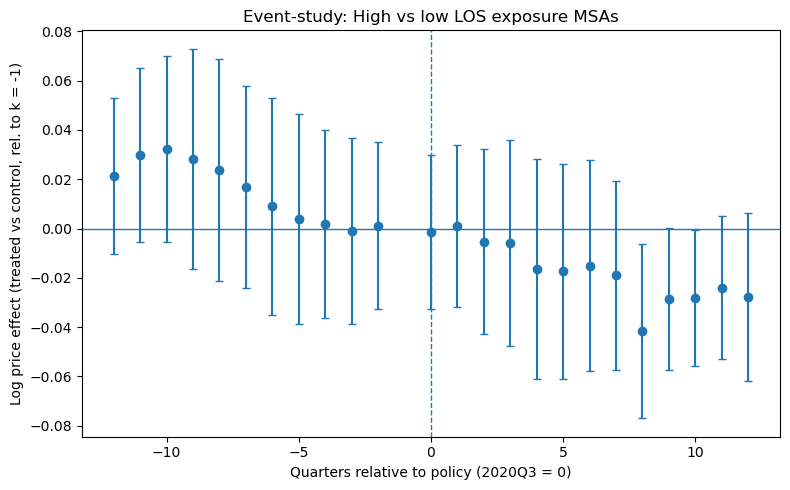

Event-study relative time points: [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [21]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

event_df = merged_sub.copy()

policy_year = 2020
policy_quarter = 3

event_df['rel_time'] = (event_df['year'] - policy_year) * 4 + (event_df['quarter'] - policy_quarter)

min_k, max_k = -12, 12

def k_to_name(k: int) -> str:
    if k < 0:
        return f"Dm{abs(k)}"   # e.g., -12 -> Dm12
    else:
        return f"Dp{k}"        # e.g., 0 -> Dp0, 12 -> Dp12

event_terms = []
for k in range(min_k, max_k + 1):
    if k == -1:
        continue  # reference period
    name = k_to_name(k)
    event_df[name] = ((event_df['rel_time'] == k) & (event_df['treat_high'] == 1)).astype(int)
    event_terms.append(name)

# (Recommended) make FE identifiers formula-friendly & cluster-friendly
event_df['place_id_fe'] = event_df['place_id'].astype(str)
event_df['time_id_fe']  = event_df['time_id'].astype(str)
clusters = event_df['place_id_fe'].to_numpy(dtype=object)

formula = 'ln_index ~ ' + ' + '.join(event_terms) + ' + C(place_id_fe) + C(time_id_fe)'

res = smf.ols(formula=formula, data=event_df).fit(
    cov_type='cluster',
    cov_kwds={'groups': clusters}
)

# Extract coefficients in k order
ks, coefs, ses = [], [], []
for k in range(min_k, max_k + 1):
    if k == -1:
        continue
    name = k_to_name(k)
    if name in res.params.index:
        ks.append(k)
        coefs.append(res.params[name])
        ses.append(res.bse[name])

ks = np.array(ks)
coefs = np.array(coefs)
ses = np.array(ses)

plt.figure(figsize=(8, 5))
plt.axhline(0, linewidth=1)
plt.axvline(0, linestyle='--', linewidth=1)
plt.errorbar(ks, coefs, yerr=1.96*ses, fmt='o', capsize=3)
plt.xlabel('Quarters relative to policy (2020Q3 = 0)')
plt.ylabel('Log price effect (treated vs control, rel. to k = -1)')
plt.title('Event-study: High vs low LOS exposure MSAs')
plt.tight_layout()
plt.show()

print("Event-study relative time points:", ks.tolist())


In [23]:
# Event-study regression around 2020Q3 and plot coefficients for high vs low LOS MSAs

# 1) Prepare data and fix dtypes
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Start from merged_sub already in memory
event_df = merged_sub.copy()

# Fix nullable Int64 dtypes which upset patsy / statsmodels
for col_name in event_df.columns:
    if str(event_df[col_name].dtype) == 'Int64':
        if event_df[col_name].isna().any():
            event_df[col_name] = event_df[col_name].astype('float64')
        else:
            event_df[col_name] = event_df[col_name].astype('int64')

# Ensure IDs are strings for fixed effects
event_df['place_id_fe'] = event_df['place_id'].astype(str)

# 2) Construct relative time to policy (2020Q3 = 0)
policy_year = 2020
policy_quarter = 3

event_df['rel_time'] = (event_df['year'] - policy_year) * 4 + (event_df['quarter'] - policy_quarter)

# Restrict to a symmetric window around policy for readability
min_k = -12
max_k = 12
mask_window = (event_df['rel_time'] >= min_k) & (event_df['rel_time'] <= max_k)
event_df = event_df.loc[mask_window].copy()

# 3) Create event-time dummies for treated group, with k = -1 as the omitted baseline
name_map = {}
for k_val in range(min_k, max_k + 1):
    if k_val == -1:
        continue
    safe_name = 'D_m' + str(abs(k_val)) if k_val < 0 else 'D_p' + str(k_val)
    name_map[k_val] = safe_name
    event_df[safe_name] = ((event_df['rel_time'] == k_val) & (event_df['treat_high'] == 1)).astype(int)

print(event_df[['year', 'quarter', 'rel_time']].head())

     year  quarter  rel_time
160  2017        3       -12
161  2017        4       -11
162  2018        1       -10
163  2018        2        -9
164  2018        3        -8


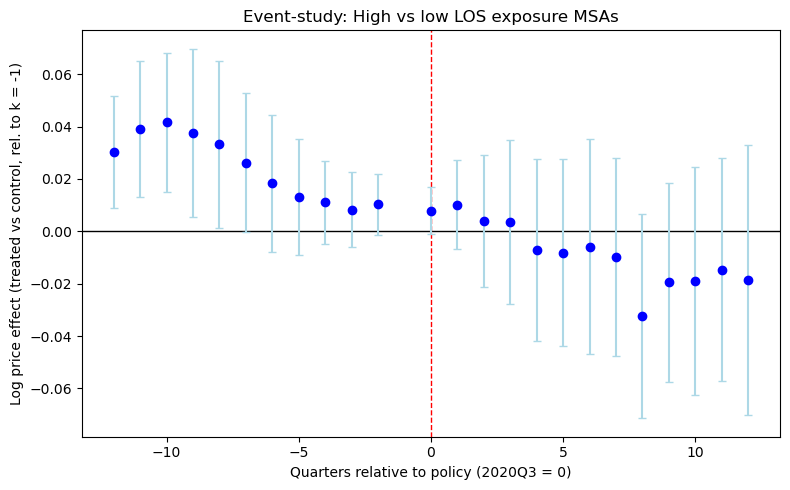

[-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2   0   1   2   3   4   5   6
   7   8   9  10  11  12]
[ 0.03043289  0.03912951  0.04165442  0.03749906  0.03313959  0.02624278
  0.01825314  0.01305234  0.01107056  0.00831795  0.01037771  0.00791175
  0.01023138  0.00389311  0.0034349  -0.00716468 -0.00815805 -0.00584955
 -0.00977357 -0.03240668 -0.01941938 -0.01901621 -0.01469569 -0.01849838]


In [24]:
# 4) Run the event-study regression and plot coefficients with clustered SE

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

# Build formula: all event-time dummies + MSA and time FE
terms = list(name_map.values())
formula = 'ln_index ~ ' + ' + '.join(terms) + ' + C(place_id_fe) + C(time_id)'

model = smf.ols(formula=formula, data=event_df)
res = model.fit(cov_type='cluster', cov_kwds={'groups': event_df['place_id']})

# Extract coefficients for each relative time k
ks = []
coefs = []
ses = []
for k_val, nm in name_map.items():
    if nm in res.params.index:
        ks.append(k_val)
        coefs.append(res.params[nm])
        ses.append(res.bse[nm])

ks = np.array(ks)
coefs = np.array(coefs)
ses = np.array(ses)

# Sort by k for clean plotting
order = np.argsort(ks)
ks = ks[order]
coefs = coefs[order]
ses = ses[order]

plt.figure(figsize=(8,5))
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.errorbar(ks, coefs, yerr=1.96*ses, fmt='o', color='blue', ecolor='lightblue', capsize=3)
plt.xlabel('Quarters relative to policy (2020Q3 = 0)')
plt.ylabel('Log price effect (treated vs control, rel. to k = -1)')
plt.title('Event-study: High vs low LOS exposure MSAs')
plt.tight_layout()
plt.show()

print(ks)
print(coefs)